In [14]:
# Optimization for Machine Learning
# Problem: projected gradient descent for SVM

%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pegasos import *
from cyclic_coordinate_descent import *
from random_coordinate_descent import *
from utils import *


from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.preprocessing import StandardScaler
import os, struct
from array import array
from SMO import SMO
from RSMO import RSMO
from SMO1 import SMO1
from RSMO1 import RSMO1

np.random.seed(1337)

kwargs = {'linewidth' : 3.5}
font = {'weight' : 'normal', 'size'   : 24}
matplotlib.rc('font', **font)


### Load mnist training and validation images. Plot examples from both sets and show their corresponding labels as verification.

In [16]:
# mnist load images
train_imgs_dir = './dataset/mnist/train-images.idx3-ubyte'
train_labels_dir = './dataset/mnist/train-labels.idx1-ubyte'
val_imgs_dir = './dataset/mnist/t10k-images.idx3-ubyte'
val_labels_dir = './dataset/mnist/t10k-labels.idx1-ubyte'
train_imgs, train_labels = mnist_data_loader(train_imgs_dir, train_labels_dir)
print("mnist: number of training examples", train_imgs.shape[0])

val_imgs, val_labels = mnist_data_loader(val_imgs_dir, val_labels_dir)
print("mnist: number of validation examples", val_imgs.shape[0])
HEIGHT = 28
WIDTH = 28

# Reshape images to vectors
train_vectors_10000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:10000, :]
train_labels_10000 = train_labels[:10000]

train_vectors_5000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:5000, :]
train_labels_5000 = train_labels[:5000]

train_vectors_3000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:3000, :]
train_labels_3000 = train_labels[:3000]

train_vectors_1000 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:1000, :]
train_labels_1000 = train_labels[:1000]

train_vectors_300 = train_imgs.reshape(-1, HEIGHT * WIDTH)[:300, :]
train_labels_300 = train_labels[:300]

val_vectors = val_imgs.reshape(-1, HEIGHT * WIDTH)

mnist: number of training examples 11769
mnist: number of validation examples 1932


## Plot Functions

In [3]:
# initialize w, lambda
# num_examples, num_features = train_vectors.shape
_, num_features = train_vectors_10000.shape

def error_plot(w, _lambda, img_vectors, labels, algorithm, dilate=1, yscale='log'):
    """plot errors"""
    error_list = cal_objective_dilate(w, _lambda, img_vectors, labels, dilate)
    print(algorithm+" error:", error_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Error')
#     plt.yscale(yscale)
    num_iters = len(error_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), error_list, **kwargs)

def cal_objective_dilate(w, _lambda, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [objective(x, _lambda, img_vectors, labels) \
                                for x in w[0:num_iters:dilate]]

def acc_plot(w, img_vectors, labels, algorithm, dilate=1):
    """plot accuracies"""
    acc_list = cal_acc_dilate(w, img_vectors, labels, dilate)
    print(algorithm+" acc:", acc_list[-1])
    plt.xlabel('Step')
    plt.ylabel('Acc')
    num_iters = len(acc_list)
    plt.plot(np.linspace(0, num_iters*dilate, num=num_iters), acc_list, **kwargs)

def cal_acc_dilate(w, img_vectors, labels, dilate=1):
    num_iters = len(w)
    return [compute_accuracy(x, img_vectors, labels) for x in w[0:num_iters:dilate]]

## Training error

In [4]:
def average_weight(w):
    w_sum = np.zeros([num_features,1])
    w_average = []
    for i in range(0,len(w)):
        w_sum += w[i]
        w_average.append(w_sum/(i+1))
    return w_average

def set_pegasos_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 3000
    return _lambda, num_steps, w0

def set_primal_cyclic_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias

def set_primal_random_cd_params():
    w0 = np.zeros([num_features,1])
    _lambda = 1
    num_steps = 4
    t_bias = 10
    return _lambda, num_steps, w0, t_bias


In [5]:
# 10000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_10000, train_labels_10000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_10000, train_labels_10000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_10000, train_labels_10000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_10000, train_labels_10000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_10000, train_labels_10000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_10000, train_labels_10000))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors_10000, train_labels_10000)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors_10000, train_labels_10000)

Pegasos training starts...
Iterations: 2999    total_time: 0.6192042827606201
Pegasos training ends...
Pegasos training error   0.09675436844890932
        
CCD training starts...
epoch: 0    total_time: 49.534754037857056
epoch: 1    total_time: 99.75341010093689
epoch: 2    total_time: 152.9945740699768
epoch: 3    total_time: 203.44283819198608
CCD training ends...
CCD training error:   0.6761411184091455
        
RCD training starts...
epoch: 0    total_time: 54.34020519256592
epoch: 1    total_time: 110.49661898612976
epoch: 2    total_time: 171.62442326545715
epoch: 3    total_time: 228.62109208106995
RCD training ends...
RCD training error:   0.699591201211422
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


Pegasos error: 0.09680411978301515
CCD error: 0.6796188506367402
RCD error: 0.7006101143251792
SMO error: 0.11821103789691031
rSMO error: 0.11640196396328045


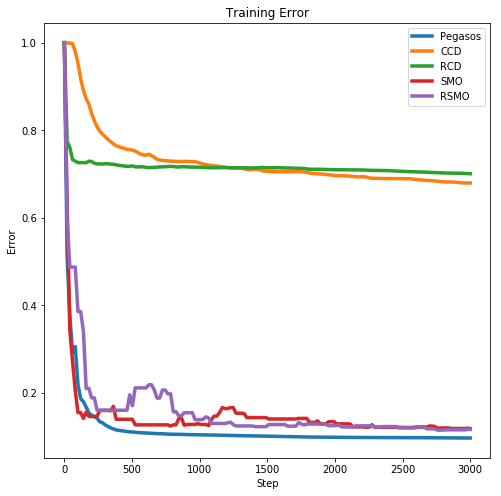

In [6]:
# training error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_10000, train_labels_10000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_10000, train_labels_10000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_10000, train_labels_10000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_10000, train_labels_10000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_10000, train_labels_10000, 'rSMO', plot_dilation)

plt.title(' Training Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [7]:
# 5000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_5000, train_labels_5000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_5000, train_labels_5000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_5000, train_labels_5000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_5000, train_labels_5000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_5000, train_labels_5000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_5000, train_labels_5000))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors_5000, train_labels_5000)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors_5000, train_labels_5000)

Pegasos training starts...
Iterations: 2999    total_time: 0.38550615310668945
Pegasos training ends...
Pegasos training error   0.09560251961554522
        
CCD training starts...
epoch: 0    total_time: 23.703619718551636
epoch: 1    total_time: 47.44494271278381
epoch: 2    total_time: 70.55698370933533
epoch: 3    total_time: 93.64204907417297
CCD training ends...
CCD training error:   0.6761313175320296
        
RCD training starts...
epoch: 0    total_time: 26.32540225982666
epoch: 1    total_time: 52.84379005432129
epoch: 2    total_time: 79.34959697723389
epoch: 3    total_time: 106.00462794303894
RCD training ends...
RCD training error:   0.6952986247654517
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


Pegasos error: 0.0956236745034325
CCD error: 0.6796036605315815
RCD error: 0.6960699497841623
SMO error: 0.1280259565474599
rSMO error: 0.11689212906253144


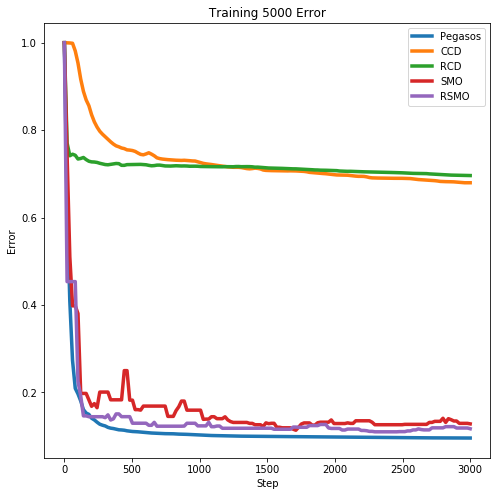

In [8]:
# training 5000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_5000, train_labels_5000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_5000, train_labels_5000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_5000, train_labels_5000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_5000, train_labels_5000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_5000, train_labels_5000, 'rSMO', plot_dilation)

plt.title(' Training 5000 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [9]:
# 3000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_3000, train_labels_3000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_3000, train_labels_3000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_3000, train_labels_3000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_3000, train_labels_3000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_3000, train_labels_3000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_3000, train_labels_3000))
print("        ")

# SVM using SMO descend
smo_model = SMO(C=1.0)
smo_model.fit(train_vectors_3000, train_labels_3000)
print("        ")

# Random SMO
rsmo_model = RSMO(C=1.0)
rsmo_model.fit(train_vectors_3000, train_labels_3000)

Pegasos training starts...
Iterations: 2999    total_time: 0.3184499740600586
Pegasos training ends...
Pegasos training error   0.0946908287183828
        
CCD training starts...
epoch: 0    total_time: 14.72780179977417
epoch: 1    total_time: 29.503150701522827
epoch: 2    total_time: 43.38481402397156
epoch: 3    total_time: 57.68457913398743
CCD training ends...
CCD training error:   0.6761647775552811
        
RCD training starts...
epoch: 0    total_time: 17.279667854309082
epoch: 1    total_time: 33.86305499076843
epoch: 2    total_time: 49.900959968566895
epoch: 3    total_time: 65.9794819355011
RCD training ends...
RCD training error:   0.6989598154351215
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


Pegasos error: 0.09470219688594383
CCD error: 0.6793413119943509
RCD error: 0.7006936244841855
SMO error: 0.11458531709237117
rSMO error: 0.11636439809080959


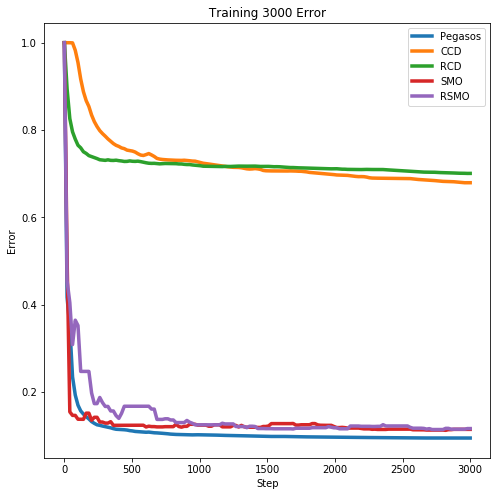

In [10]:
# training 3000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_3000, train_labels_3000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_3000, train_labels_3000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_3000, train_labels_3000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_3000, train_labels_3000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_3000, train_labels_3000, 'rSMO', plot_dilation)

plt.title(' Training 3000 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [17]:
# 1000
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_1000, train_labels_1000, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_1000, train_labels_1000)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_1000, train_labels_1000, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_1000, train_labels_1000))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_1000, train_labels_1000, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_1000, train_labels_1000))
print("        ")

# SVM using SMO descend
smo_model = SMO1(C=1.0)
smo_model.fit(train_vectors_1000, train_labels_1000)
print("        ")

# Random SMO
rsmo_model = RSMO1(C=1.0)
rsmo_model.fit(train_vectors_1000, train_labels_1000)

Pegasos training starts...
Iterations: 2999    total_time: 0.21071314811706543
Pegasos training ends...
Pegasos training error   0.08384441730475768
        
CCD training starts...
epoch: 0    total_time: 5.010993003845215
epoch: 1    total_time: 9.767129898071289
epoch: 2    total_time: 14.447202205657959
epoch: 3    total_time: 19.079224824905396
CCD training ends...
CCD training error:   0.6811844243728516
        
RCD training starts...
epoch: 0    total_time: 5.336473226547241
epoch: 1    total_time: 11.214823961257935
epoch: 2    total_time: 16.713361263275146
epoch: 3    total_time: 22.271132230758667
RCD training ends...
RCD training error:   0.692985573310908
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


Pegasos error: 0.08387830376763261
CCD error: 0.6841777627812141
RCD error: 0.6944658134560431
SMO error: 0.12899240482424276
rSMO error: 0.12794893187385664


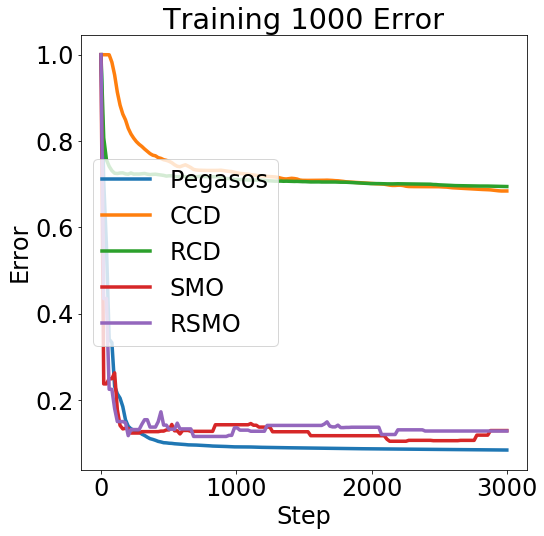

In [18]:
# training 1000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_1000, train_labels_1000, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_1000, train_labels_1000, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_1000, train_labels_1000, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_1000, train_labels_1000, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_1000, train_labels_1000, 'rSMO', plot_dilation)

plt.title(' Training 1000 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

In [19]:
# 300
# pegasos
pegasos_lambda, pegasos_num_steps, w0 = set_pegasos_params()   # initialize params
pegasos_weight, pegasos_running_time = pegasos_gradient_descent(\
                        w0, [pegasos_lambda]*pegasos_num_steps, train_vectors_300, train_labels_300, proj)   # training
pegasos_output_weight = average_weight(pegasos_weight.copy())  # average weights as outputs
print("Pegasos training error  ", objective(pegasos_output_weight[-1], pegasos_lambda, train_vectors_300, train_labels_300)) # print final training error
print("        ")

# primal cyclic coordinate descent
primal_cyclic_cd_lambda, primal_cyclic_cd_num_steps, w0, t_bias = set_primal_cyclic_cd_params()
primal_cyclic_cd_weight, primal_cyclic_cd_running_time = cyclic_coordinate_descent_primal_subgradient( \
                        w0, [primal_cyclic_cd_lambda]*primal_cyclic_cd_num_steps, train_vectors_300, train_labels_300, t_bias, proj)
primal_cyclic_cd_output_weight = average_weight(primal_cyclic_cd_weight.copy())
print("CCD training error:  ", objective(primal_cyclic_cd_output_weight[-1], primal_cyclic_cd_lambda, train_vectors_300, train_labels_300))
print("        ")

# primal random coordinate descent
primal_random_cd_lambda, primal_random_cd_num_steps, w0, t_bias = set_primal_random_cd_params()
primal_random_cd_weight, primal_random_cd_running_time = random_coordinate_descent_primal_subgradient( \
                        w0, [primal_random_cd_lambda]*primal_random_cd_num_steps, train_vectors_300, train_labels_300, t_bias, proj)
primal_random_cd_output_weight = average_weight(primal_random_cd_weight.copy())
print("RCD training error:  ", objective(primal_random_cd_output_weight[-1], primal_random_cd_lambda, train_vectors_300, train_labels_300))
print("        ")

# SVM using SMO descend
smo_model = SMO1(C=1.0)
smo_model.fit(train_vectors_300, train_labels_300)
print("        ")

# Random SMO
rsmo_model = RSMO1(C=1.0)
rsmo_model.fit(train_vectors_300, train_labels_300)

Pegasos training starts...
Iterations: 2999    total_time: 0.18555712699890137
Pegasos training ends...
Pegasos training error   0.07269445746850273
        
CCD training starts...
epoch: 0    total_time: 1.5007009506225586
epoch: 1    total_time: 3.1414237022399902
epoch: 2    total_time: 4.713778734207153
epoch: 3    total_time: 6.289310932159424
CCD training ends...
CCD training error:   0.682273680998512
        
RCD training starts...
epoch: 0    total_time: 1.8102307319641113
epoch: 1    total_time: 3.7096519470214844
epoch: 2    total_time: 5.629653692245483
epoch: 3    total_time: 7.495881795883179
RCD training ends...
RCD training error:   0.6870534890665904
        
SMO training start
SMO training ends....
        
RSMO training start
RSMO training ends....


Pegasos error: 0.07277160641953417
CCD error: 0.685085680147801
RCD error: 0.6886727312032385
SMO error: 0.12342464754972653
rSMO error: 0.11558012143989839


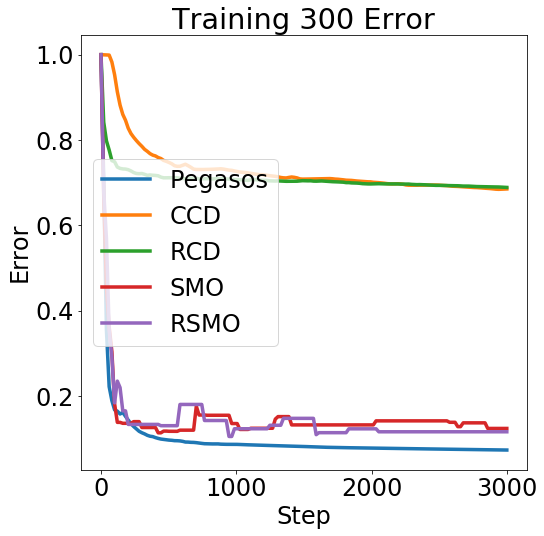

In [20]:
# training 3000 error plot
plot_dilation = 20
plt.figure(figsize=(8, 8))
plot_iters = 3000

error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, train_vectors_300, train_labels_300, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, train_vectors_300, train_labels_300, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, train_vectors_300, train_labels_300, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, train_vectors_300, train_labels_300, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, train_vectors_300, train_labels_300, 'rSMO', plot_dilation)

plt.title(' Training 300 Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9822
CCD acc: 0.9307
RCD acc: 0.9727
SMO acc: 0.9793
rSMO acc: 0.9793


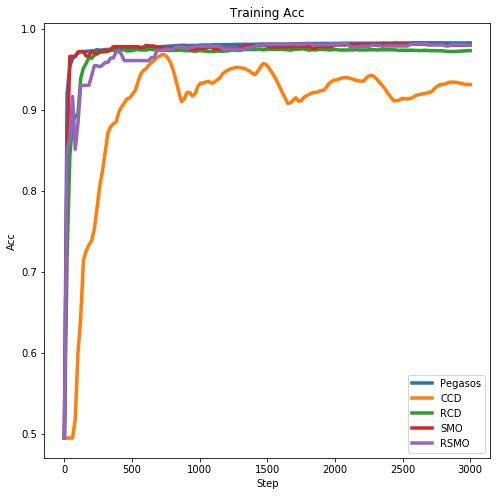

In [11]:
# training acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], train_vectors_10000, train_labels_10000, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], train_vectors_10000, train_labels_10000, 'rSMO', plot_dilation)

plt.title(' Training Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos error: 0.09974326236353649
CCD error: 0.6880217535964669
RCD error: 0.7029267315163804
SMO error: 0.11921207776903921
rSMO error: 0.11363097299983119


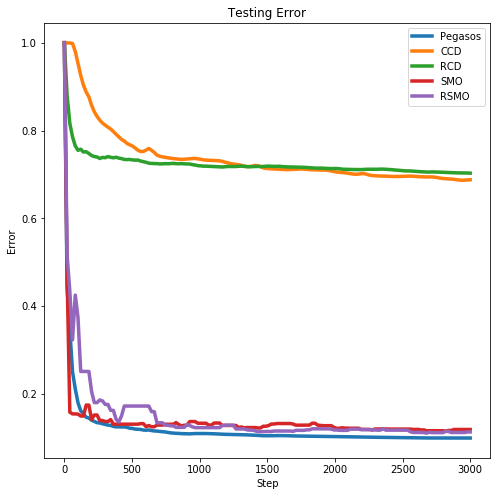

In [12]:
# test error plot
plt.figure(figsize=(8, 8))
error_plot(pegasos_output_weight[:plot_iters], pegasos_lambda, val_vectors, val_labels, 'Pegasos', plot_dilation)
error_plot(primal_cyclic_cd_output_weight[:plot_iters], primal_cyclic_cd_lambda, val_vectors, val_labels, 'CCD', plot_dilation)
error_plot(primal_random_cd_output_weight[:plot_iters], primal_random_cd_lambda, val_vectors, val_labels, 'RCD', plot_dilation)
error_plot(smo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'SMO', plot_dilation)
error_plot(rsmo_model.w_ls[:plot_iters], 1.0, val_vectors, val_labels, 'rSMO', plot_dilation)
plt.title(' Testing Error ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])

Pegasos acc: 0.9808488612836439
CCD acc: 0.9161490683229814
RCD acc: 0.9694616977225673
SMO acc: 0.9772256728778468
rSMO acc: 0.9813664596273292


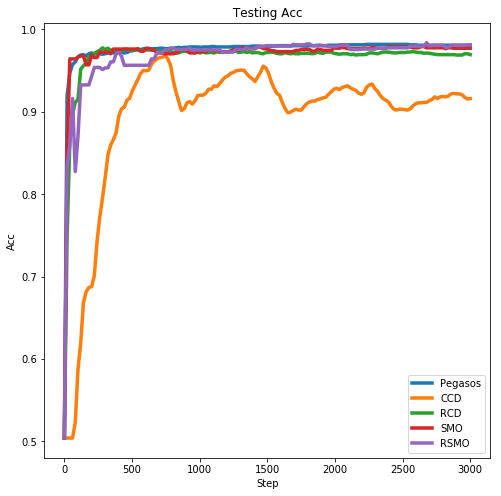

In [13]:
# test acc plot
plt.figure(figsize=(8, 8))
acc_plot(pegasos_output_weight[:plot_iters], val_vectors, val_labels, 'Pegasos', plot_dilation)
acc_plot(primal_cyclic_cd_output_weight[:plot_iters], val_vectors, val_labels, 'CCD', plot_dilation)
acc_plot(primal_random_cd_output_weight[:plot_iters], val_vectors, val_labels, 'RCD', plot_dilation)
acc_plot(smo_model.w_ls[:plot_iters], val_vectors, val_labels, 'SMO', plot_dilation)
acc_plot(rsmo_model.w_ls[:plot_iters], val_vectors, val_labels, 'rSMO', plot_dilation)

plt.title(' Testing Acc ')
plt.legend(['Pegasos', 'CCD', 'RCD', 'SMO', 'RSMO'])